In [1]:
pip install git+https://github.com/ml-jku/hopfield-layers

  Cloning https://github.com/ml-jku/hopfield-layers to /tmp/pip-req-build-ci7o420d
  Running command git clone --filter=blob:none --quiet https://github.com/ml-jku/hopfield-layers /tmp/pip-req-build-ci7o420d
  Resolved https://github.com/ml-jku/hopfield-layers to commit f56f929c95b77a070ae675ea4f56b6d54d36e730
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━

In [2]:
pip install pandas seaborn numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Import the Hopfield layer
from hflayers import HopfieldPooling

In [4]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        # Feature extractor blocks
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        # Input: (batch, 1, 28, 28) -> Output: (batch, 32, 28, 28)
        self.pool1 = nn.MaxPool2d(2, 2)
        # Output: (batch, 32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        # Output: (batch, 64, 14, 14)
        self.pool2 = nn.MaxPool2d(2, 2)
        # Output: (batch, 64, 7, 7)

        # Classifier head
        # The nn.Flatten() layer replaces the traditional.view()
        self.flatten = nn.Flatten()
        # Input: (batch, 64, 7, 7) -> Output: (batch, 64 * 7 * 7) = (batch, 3136)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 10) # 10 classes for MNIST

    def forward(self, x):
        # Feature extraction
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        # Aggregation and classification
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # Note: We return raw logits for compatibility with nn.CrossEntropyLoss
        # and adversarial attack libraries
        return x

In [5]:
class HopfieldCNN(nn.Module):
    def __init__(self):
        super(HopfieldCNN, self).__init__()
        # Feature extractor is IDENTICAL to the baseline
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        # Output of feature extractor: (batch, 64, 7, 7)

        # === Key Architectural Difference ===
        # The output of conv2 is (batch, 64, 7, 7)
        # This is (batch_size, num_features, height, width)
        # HopfieldPooling pools over a "sequence." We will treat the
        # spatial locations (7*7 = 49) as the sequence, and the
        # channels (64) as the feature dimension.
        
        # 1. We must define the HopfieldPooling layer.
        #    The input_size is the feature dimension of each item
        #    in the sequence, which is 64 (the number of channels).
        self.hopfield_pool = HopfieldPooling(
            input_size=64,
            # We can add other Hopfield parameters here if desired
        )
        # The HopfieldPooling layer will output one vector per batch item,
        # of size equal to input_size (64).
        # Output: (batch, 64)

        # 2. The classifier head now takes (batch, 64) as input
        self.fc1 = nn.Linear(64, 1024) # Input size is 64, not 3136
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        # Feature extraction
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        # === Aggregation and classification ===
        
        # Original shape: (batch_size, 64, 7, 7)
        
        # Reshape for HopfieldPooling:
        # We need (batch_size, sequence_length, feature_dimension)
        # New shape: (batch_size, 49, 64)
        batch_size = x.shape
        # Flatten the spatial dimensions (H, W) into one
        x = x.flatten(2) # Shape: (batch_size, 64, 49)
        # Permute to (batch_size, 49, 64)
        x = x.permute(0, 2, 1) 

        # Apply Hopfield pooling
        # This layer learns a static query and uses it to
        # pool the 49-item sequence into a single 64-dim vector.
        x = self.hopfield_pool(x) # Shape: (batch_size, 64)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
class HopfieldCNN_V3(nn.Module):
    """
    V3 Model: Combines V2's tuning with Dropout.
    
    Changes:
    1.  Includes the same Hopfield tuning as V2.
    2.  Adds a nn.Dropout layer (p=0.5) after the main
        ReLU activation in the classifier. This is a very
        common and effective form of regularization.
    """
    def __init__(self):
        super(HopfieldCNN_V3, self).__init__()
        # Feature extractor is identical
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)

        # === Key Architectural Difference ===
        self.hopfield_pool = HopfieldPooling(
            input_size=64,
            scaling_factor=8.0,
            num_heads=4,
        )
        
        # Classifier head
        self.fc1 = nn.Linear(64, 1024)
        self.dropout = nn.Dropout(p=0.5) # <-- NEW: Added Dropout
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        # Feature extraction
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        # Reshape for HopfieldPooling
        batch_size = x.shape[0]
        x = x.flatten(2) # Shape: (batch_size, 64, 49)
        x = x.permute(0, 2, 1) # Shape: (batch_size, 49, 64)

        # Apply Hopfield pooling
        x = self.hopfield_pool(x) # Shape: (batch_size, 64)
        
        # Classification
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # <-- NEW: Apply dropout here
        x = self.fc2(x)
        return x

# -------------------------------------------------------------------
# Option 3: The "Gold Standard" - Adversarial Training
# -------------------------------------------------------------------

def train_model_adversarial(model, train_loader, epochs=5):
    """
    This is a new training function that implements
    simple PGD-based adversarial training.
    
    Instead of just training on `data`, we first create an
    adversarial version of `data` (called `adv_data`)
    and then train the model on that.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # --- Adversarial Training Setup ---
    # 1. Wrap the model for Foolbox.
    #    NOTE: We are using the *training* normalization stats.
    preprocessing = dict(mean=[0.1307], std=[0.3081], axis=-3)
    bounds = (0, 1) # Assumes ToTensor() was used
    fmodel = fb.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing)
    
    # 2. Define the attack to use for training.
    #    A simple PGD attack is standard.
    #    - We use a small epsilon (0.1)
    #    - We use a small step size (0.01)
    #    - We use very few steps (7-10) to keep training fast.
    attack = fb.attacks.PGD(steps=7, rel_stepsize=0.1)
    
    # 3. Define the epsilon for the attack
    #    This is the "strength" of the attack used in training.
    #    This is a key hyperparameter to tune.
    train_epsilon = 0.1
    # ----------------------------------
    
    for epoch in range(epochs):
        model.train() # Make sure model is in train mode
        
        progress_bar = tqdm(train_loader, desc=f"Adv. Epoch {epoch+1}/{epochs}")
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)
            
            # --- Generate Adversarial Examples ---
            # 1. We must detach data/target from the graph for the attack
            # 2. We set epsilons to our training epsilon
            # 3. We use .detach() on the result so the gradient
            #    from the *attack* doesn't flow back. We only
            #    want the gradient from the *model's loss*.
            _, adv_data, _ = attack(fmodel, data, target, epsilons=train_epsilon)
            adv_data = adv_data.detach()
            
            # --- Standard Training Step (but on adv_data) ---
            optimizer.zero_grad()
            output = model(adv_data) # <-- Train on attacked data
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    print("Adversarial training complete.")
    # NOTE: After this, evaluate the model on the *clean*
    # test set to see its normal accuracy, and then run your
    # attack script to see its *robust* accuracy.

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
# Assuming your model definitions for BaselineCNN and HopfieldCNN exist elsewhere

def get_mnist_loader(batch_size=64):
    # FIX: Provide a list of transformations to Compose
    # 1. ToTensor() converts images to PyTorch Tensors and scales pixel values to [0, 1]
    # 2. Normalize() adjusts tensor values to have a mean of 0.1307 and a std dev of 0.3081
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Your other functions (train_model, evaluate_model) are correct
# ...
def train_model(model, train_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    for epoch in range(epochs):
        # Wrap train_loader with tqdm for a progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            # Update the progress bar with the current loss
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    accuracy = 100. * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy

# --- Main execution ---
train_loader, test_loader = get_mnist_loader()

# Train Baseline Model
print("Training Baseline CNN...")
baseline_model = BaselineCNN()
train_model(baseline_model, train_loader, epochs=5)
evaluate_model(baseline_model, test_loader)
torch.save(baseline_model.state_dict(), "baseline_cnn.pth")

# Train Hopfield Model
print("\nTraining Hopfield-Pooling CNN...")
hopfield_model = HopfieldCNN()
train_model(hopfield_model, train_loader, epochs=5)
evaluate_model(hopfield_model, test_loader)
torch.save(hopfield_model.state_dict(), "hopfield_cnn.pth")

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.34MB/s]


Training Baseline CNN...


Epoch 5/5: 100%|██████████| 938/938 [00:09<00:00, 95.40it/s, loss=0.0169]


Accuracy on test set: 99.09%

Training Hopfield-Pooling CNN...


Epoch 5/5: 100%|██████████| 938/938 [00:11<00:00, 80.39it/s, loss=0.0488]


Accuracy on test set: 97.83%


Foolboxpip install foolbox

In [8]:
pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
import torchvision
import foolbox as fb
import numpy as np

# Import model definitions from the previous script
# (Assuming they are in a file named `models.py`)
# from models import BaselineCNN, HopfieldCNN

# For this tutorial, we will redefine them here
#... (Paste BaselineCNN and HopfieldCNN class definitions here)...
#... (Paste get_mnist_loader function here)...

# Load the trained model weights
baseline_model = BaselineCNN()
baseline_model.load_state_dict(torch.load("baseline_cnn.pth"))
baseline_model.eval() # Set to evaluation mode

hopfield_model = HopfieldCNN()
hopfield_model.load_state_dict(torch.load("hopfield_cnn.pth"))
hopfield_model.eval() # Set to evaluation mode

device = torch.device("cuda"if torch.cuda.is_available() else "cpu")
baseline_model.to(device)
hopfield_model.to(device)

HopfieldCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hopfield_pool): HopfieldPooling(
    (hopfield): Hopfield(
      (association_core): HopfieldCore(
        (out_proj): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm_stored_pattern): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm_state_pattern): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm_pattern_projection): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc1): Linear(in_features=64, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [10]:
import torch
import foolbox as fb
from tqdm import tqdm

# --- Step 1: Load Models and UN-NORMALIZED Data ---
# It's crucial to use a loader that ONLY applies ToTensor() for the attack script.
# This provides images in the [0, 1] range that Foolbox expects.
# (Assuming you have defined `get_mnist_loader_unnormalized` elsewhere)
_, test_loader = get_mnist_loader(batch_size=100)
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# --- Step 2: Wrap Models for Foolbox ---
# This part is correct. You provide raw bounds and tell Foolbox how to preprocess.
preprocessing = dict(mean=[0.1307], std=[0.3081], axis=-3)
bounds = (0, 1)
fmodel_baseline = fb.PyTorchModel(baseline_model, bounds=bounds, preprocessing=preprocessing)
fmodel_hopfield = fb.PyTorchModel(hopfield_model, bounds=bounds, preprocessing=preprocessing)

# --- Step 3: Pre-Filter for Correctly Classified Images ---
# It only makes sense to attack images the model gets RIGHT.
print("Pre-filtering images...")
with torch.no_grad():
    preds_baseline = fmodel_baseline(images).argmax(axis=1)
    preds_hopfield = fmodel_hopfield(images).argmax(axis=1)

# Find images that BOTH models classified correctly
correct_mask = (preds_baseline == labels) & (preds_hopfield == labels)
clean_images = images[correct_mask]
clean_labels = labels[correct_mask]

print(f"Attacking {len(clean_images)} images (correctly classified by both models).")

# --- Step 4: Instantiate and Run the Attack (with Progress & Error Handling) ---
attack = fb.attacks.HopSkipJumpAttack(steps=50)

# Check if there are any images to attack to prevent errors with empty tensors
if len(clean_images) == 0:
    print("No images were correctly classified by both models. Skipping attack.")
    # You can set default values or exit if needed
    advs_baseline = torch.empty_like(clean_images)
    success_baseline = torch.empty_like(clean_labels, dtype=torch.bool)
    advs_hopfield = torch.empty_like(clean_images)
    success_hopfield = torch.empty_like(clean_labels, dtype=torch.bool)
else:
    # -- Attack Baseline Model --
    all_advs_baseline = []
    all_success_baseline = []
    print("\nAttacking Baseline CNN...")
    for image, label in tqdm(zip(clean_images, clean_labels), total=len(clean_images)):
        image_batch, label_batch = image.unsqueeze(0), label.unsqueeze(0)
        
        try:
            # Unpack the attack results explicitly
            raw_advs, clipped_advs, success = attack(fmodel_baseline, image_batch, label_batch, epsilons=None)
            all_advs_baseline.append(clipped_advs)
            all_success_baseline.append(success)
        except ValueError:
            # Handle cases where the attack cannot start (a successful defense)
            print(f"\nWarning: Baseline attack failed to initialize. Counting as a failed attack.")
            all_advs_baseline.append(image_batch) # Append original image
            # FIX: Create a 1D tensor with shape (1,) to match successful returns
            all_success_baseline.append(torch.tensor([False]).to(device))

    # Combine the list of results back into a single tensor
    advs_baseline = torch.cat(all_advs_baseline)
    success_baseline = torch.cat(all_success_baseline).squeeze()

    # -- Attack Hopfield Model --
    all_advs_hopfield = []
    all_success_hopfield = []
    print("\nAttacking Hopfield-Pooling CNN...")
    for image, label in tqdm(zip(clean_images, clean_labels), total=len(clean_images)):
        image_batch, label_batch = image.unsqueeze(0), label.unsqueeze(0)
        
        try:
            raw_advs, clipped_advs, success = attack(fmodel_hopfield, image_batch, label_batch, epsilons=None)
            all_advs_hopfield.append(clipped_advs)
            all_success_hopfield.append(success)
        except ValueError:
            print(f"\nWarning: Hopfield attack failed to initialize. Counting as a failed attack.")
            all_advs_hopfield.append(image_batch)
            # FIX: Create a 1D tensor with shape (1,)
            all_success_hopfield.append(torch.tensor([False]).to(device))

    # Combine the list of results back into a single tensor
    advs_hopfield = torch.cat(all_advs_hopfield)
    success_hopfield = torch.cat(all_success_hopfield).squeeze()

print("\nAttacks completed.")

Pre-filtering images...
Attacking 32 images (correctly classified by both models).

Attacking Baseline CNN...


100%|██████████| 32/32 [06:31<00:00, 12.23s/it]



Attacking Hopfield-Pooling CNN...


100%|██████████| 32/32 [19:20<00:00, 36.26s/it]


Attacks completed.


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import foolbox as fb
import torch
from tqdm import tqdm
import numpy as np

In [12]:
def calculate_metrics_v2(clean_images, advs, success):
    """
    Calculates ASR and Mean L2, returning 'nan' if no attacks succeed.
    """
    # Calculate Attack Success Rate (ASR)
    asr = success.float().mean().item() * 100.0
    
    # Calculate Mean L2 Perturbation for SUCCESSFUL attacks
    perturbations = advs - clean_images
    l2_norms = perturbations.flatten(1).norm(p=2, dim=1)
    
    # Only average over successful attacks
    if success.sum().item() > 0:
        mean_l2 = l2_norms[success].mean().item()
    else:
        # 'nan' (Not a Number) is handled gracefully by plotting libraries
        mean_l2 = float('nan') 
        
    return asr, mean_l2

In [13]:
attacks_whitebox = [
    ('FGSM', fb.attacks.FGSM()),
    ('PGD', fb.attacks.PGD(steps=10)) # 10 steps is a common default
]

# Define the perturbation budgets to test
epsilons = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# Store results in a list for plotting
whitebox_results_list = []

# --- IMPORTANT ---
# This cell assumes 'fmodel_baseline', 'fmodel_hopfield', 
# 'clean_images', and 'clean_labels' are all in memory from your
# previous cells.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if 'fmodel_baseline' not in locals():
    print("ERROR: 'fmodel_baseline' not found.")
    print("Please re-run your previous notebook cells to load models and data.")
else:
    print(f"Running FGSM and PGD attacks on {len(clean_images)} images...")

    for attack_name, attack_fn in attacks_whitebox:
        print(f"  Testing {attack_name}...")
        
        # --- Attack Baseline ---
        # We run the attack once, passing all epsilons.
        # This is much faster than looping.
        _, _, success_baseline = attack_fn(
            fmodel_baseline, clean_images, clean_labels, epsilons=epsilons
        )
        
        # --- Attack Hopfield ---
        _, _, success_hopfield = attack_fn(
            fmodel_hopfield, clean_images, clean_labels, epsilons=epsilons
        )

        # Process results
        # success_baseline is a tensor of shape [num_epsilons, batch_size]
        asr_baseline_per_eps = success_baseline.float().mean(axis=-1).cpu().numpy() * 100.0
        asr_hopfield_per_eps = success_hopfield.float().mean(axis=-1).cpu().numpy() * 100.0

        # Add to our list for the DataFrame
        for i, eps in enumerate(epsilons):
            whitebox_results_list.append({
                'attack': attack_name,
                'model': 'Baseline CNN',
                'epsilon': eps,
                'asr': asr_baseline_per_eps[i]
            })
            whitebox_results_list.append({
                'attack': attack_name,
                'model': 'Hopfield CNN',
                'epsilon': eps,
                'asr': asr_hopfield_per_eps[i]
            })

    print("White-box attacks complete.")

    # Create the DataFrame
    df_whitebox = pd.DataFrame(whitebox_results_list)
    print("\nWhite-Box Attack Results:")
    print(df_whitebox.head())

Running FGSM and PGD attacks on 32 images...
  Testing FGSM...
  Testing PGD...
White-box attacks complete.

White-Box Attack Results:
  attack         model  epsilon     asr
0   FGSM  Baseline CNN     0.00   0.000
1   FGSM  Hopfield CNN     0.00   0.000
2   FGSM  Baseline CNN     0.01   0.000
3   FGSM  Hopfield CNN     0.01  25.000
4   FGSM  Baseline CNN     0.05   3.125


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


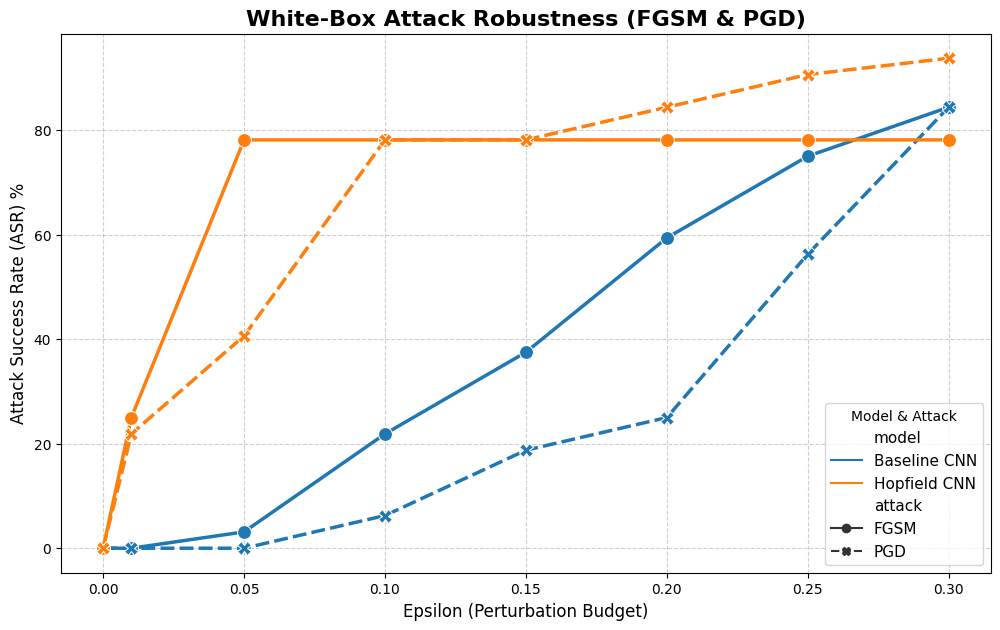

In [14]:
if not df_whitebox.empty:
    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=df_whitebox,
        x='epsilon',
        y='asr',
        hue='model',     # Color-code by model
        style='attack',  # Differentiate attacks by line style
        markers=True,
        markersize=10,
        linewidth=2.5
    )
    plt.title('White-Box Attack Robustness (FGSM & PGD)', fontsize=16, weight='bold')
    plt.xlabel('Epsilon (Perturbation Budget)', fontsize=12)
    plt.ylabel('Attack Success Rate (ASR) %', fontsize=12)
    plt.legend(fontsize=11, title='Model & Attack')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("No white-box results to plot. Please run the previous cell.")


In [15]:
attack = fb.attacks.L2CarliniWagnerAttack(steps=100) # Use fewer steps for a quick test
attack_name = "C&W L2"
cw_results_list = [] # Store C&W results here

if 'fmodel_baseline' not in locals():
    print("ERROR: 'fmodel_baseline' not found.")
    print("Please re-run your previous notebook cells to load models and data.")
else:
    # -- Attack Baseline Model (C&W) --
    all_advs_baseline_cw = []
    all_success_baseline_cw = []
    print(f"\nAttacking Baseline CNN with {attack_name}...")
    for image, label in tqdm(zip(clean_images, clean_labels), total=len(clean_images)):
        image_batch, label_batch = image.unsqueeze(0), label.unsqueeze(0)
        try:
            raw_advs, clipped_advs, success = attack(fmodel_baseline, image_batch, label_batch, epsilons=None)
            all_advs_baseline_cw.append(clipped_advs)
            all_success_baseline_cw.append(success)
        except ValueError:
            all_advs_baseline_cw.append(image_batch)
            all_success_baseline_cw.append(torch.tensor([False]).to(device))

    advs_baseline_cw = torch.cat(all_advs_baseline_cw)
    success_baseline_cw = torch.cat(all_success_baseline_cw).squeeze()

    # -- Attack Hopfield Model (C&W) --
    all_advs_hopfield_cw = []
    all_success_hopfield_cw = []
    print(f"\nAttacking Hopfield-Pooling CNN with {attack_name}...")
    for image, label in tqdm(zip(clean_images, clean_labels), total=len(clean_images)):
        image_batch, label_batch = image.unsqueeze(0), label.unsqueeze(0)
        try:
            raw_advs, clipped_advs, success = attack(fmodel_hopfield, image_batch, label_batch, epsilons=None)
            all_advs_hopfield_cw.append(clipped_advs)
            all_success_hopfield_cw.append(success)
        except ValueError:
            all_advs_hopfield_cw.append(image_batch)
            all_success_hopfield_cw.append(torch.tensor([False]).to(device))

    advs_hopfield_cw = torch.cat(all_advs_hopfield_cw)
    success_hopfield_cw = torch.cat(all_success_hopfield_cw).squeeze()

    print(f"\n{attack_name} attacks completed.")

    # Calculate and store metrics for C&W
    asr_cw_baseline, l2_cw_baseline = calculate_metrics_v2(clean_images, advs_baseline_cw, success_baseline_cw)
    asr_cw_hopfield, l2_cw_hopfield = calculate_metrics_v2(clean_images, advs_hopfield_cw, success_hopfield_cw)

    cw_results_list.append({
        'attack': attack_name, 'model': 'Baseline CNN', 'asr': asr_cw_baseline, 'mean_l2': l2_cw_baseline
    })
    cw_results_list.append({
        'attack': attack_name, 'model': 'Hopfield CNN', 'asr': asr_cw_hopfield, 'mean_l2': l2_cw_hopfield
    })



Attacking Baseline CNN with C&W L2...


100%|██████████| 32/32 [01:24<00:00,  2.64s/it]



Attacking Hopfield-Pooling CNN with C&W L2...


100%|██████████| 32/32 [02:04<00:00,  3.90s/it]


C&W L2 attacks completed.


In [16]:
if not cw_results_list:
    print("C&W results not found. Please run the previous cell.")
elif 'asr_baseline' not in locals():
    print("ERROR: HopSkipJump results ('asr_baseline', etc.) not found in memory.")
    print("Please re-run your *original* final two cells to get the HSJA results.")
else:
    print("Combining HopSkipJump (from memory) and C&W (new) results...")
    
    # Start with the C&W results we just calculated
    all_slower_results = list(cw_results_list)
    
    # --- THIS IS THE KEY "CONTINUATION" STEP ---
    # We add your original HopSkipJump results, which should
    # still be in your notebook's memory from your last cell.
    
    # (The variables `asr_baseline`, `l2_baseline`, `asr_hopfield`, 
    # and `l2_hopfield` are from your original code's final cell)
    all_slower_results.append({
        'attack': 'HopSkipJump', 
        'model': 'Baseline CNN', 
        'asr': asr_baseline,    # <--- From your previous cell
        'mean_l2': l2_baseline  # <--- From your previous cell
    })
    all_slower_results.append({
        'attack': 'HopSkipJump', 
        'model': 'Hopfield CNN', 
        'asr': asr_hopfield,    # <--- From your previous cell
        'mean_l2': l2_hopfield  # <--- From your previous cell
    })

    # Create the final DataFrame for plotting
    df_slower = pd.DataFrame(all_slower_results)
    
    print("\nCombined Slower Attack Results:")
    print(df_slower.to_markdown(index=False, floatfmt=".2f"))

    # --- Plot the combined results ---
    
    # Create a 1x2 grid of plots
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot 1: Attack Success Rate (ASR)
    sns.barplot(
        ax=axes[0],
        data=df_slower,
        x='attack',
        y='asr',
        hue='model',
        palette='viridis'
    )
    axes[0].set_title('Slower Attacks: Success Rate (ASR)', fontsize=16, weight='bold')
    axes[0].set_ylabel('Attack Success Rate (ASR) %', fontsize=12)
    axes[0].set_xlabel('Attack Type', fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, linestyle='--', axis='y', alpha=0.6)

    # Plot 2: Mean L2 Perturbation
    sns.barplot(
        ax=axes[1],
        data=df_slower,
        x='attack',
        y='mean_l2',
        hue='model',
        palette='plasma'
    )
    axes[1].set_title('Slower Attacks: Mean L2 Perturbation', fontsize=16, weight='bold')
    axes[1].set_ylabel('Mean L2 Norm (for successful attacks)', fontsize=12)
    axes[1].set_xlabel('Attack Type', fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, linestyle='--', axis='y', alpha=0.6)

    plt.suptitle('Comparison of Slower, Optimization-Based Attacks', fontsize=20, y=1.03)
    plt.tight_layout()
    plt.show()

ERROR: HopSkipJump results ('asr_baseline', etc.) not found in memory.
Please re-run your *original* final two cells to get the HSJA results.
